In [1]:
# Standardne biblioteke
import os
import io
import json
import zipfile
import requests

# Rad sa podacima i analizom
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely.geometry
import scipy.signal
from sklearn.preprocessing import MinMaxScaler

# Vizualizacija podataka
import matplotlib.pyplot as plt
from PIL import Image

# Sentinel Hub API
from sentinelhub import (
    SHConfig,
    SentinelHubRequest,
    SentinelHubStatistical,
    DataCollection,
    MimeType,
    MosaickingOrder,
    BBox,
    bbox_to_dimensions,
    CRS
)

import zipfile
import tempfile

# # openEO API
# import openeo
# from openeo.processes import multiply, add, reduce_dimension, mean
# from openeo.extra.job_management import MultiBackendJobManager

# Copernicus Data Store API
import cdsapi

# Custom funkcije iz utils.py
from utils import (
    get_eval_script, 
    add_year_month, 
    group_data, 
    plot_time_series, 
    fetch_data_for_ndvi_year, 
    fetch_data_for_moisi_year, 
    read_grib_from_zip, 
    plot_monthly_temperature,
    plot_precipitation_by_month,
    calculate_vri,
    check_and_download_zip
)

from vri import generate_vri


In [2]:
config=SHConfig("cdse")
client = cdsapi.Client(url='https://cds.climate.copernicus.eu/api', key='24c1dee0-725b-4152-b481-106a135bbebe')

2025-03-09 13:32:48,877 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-09 13:32:48,878 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


In [4]:
evalscript_ndvi=get_eval_script("NDVI")
evalscript_moisi=get_eval_script("MOISI")

In [ ]:
# Palermo: ITG12​
# Wikipedia
# Katanija: ITG17
NUTS3='EL642'  NUTS3 bbox years key
# NUTS3='EVVIA'

# # Load the GeoJSON file
geojson_path = '/home/eouser/Desktop/VRI/data/NUTS_RG_60M_2024_4326.geojson'
gdf = gpd.read_file(geojson_path)

# Filter the GeoDataFrame for the NUTS 3 code 'EL642'
gdf = gdf[gdf['NUTS_ID'] == f"{NUTS3}"]

minx, miny, maxx, maxy = gdf.total_bounds
bbox = [minx, miny, maxx, maxy]

# Lista godina za koje želimo podatke
years = ["2019","2020", "2021","2022", "2023"]
# years = [2015,2016, 2017,2018, 2019]

bbox=[
  23.057833,
  38.621162,
  23.854745,
  39.019184
]

zip_path_prec = f"/home/eouser/Desktop/VRI/data/precipitation_{NUTS3}.zip"
zip_path_temp = f"/home/eouser/Desktop/VRI/data/temp_{NUTS3}.zip"
# zip_path = "/home/eouser/Desktop/VRI/data/total_precipitation.zip"
extract_path = "/home/eouser/Desktop/VRI/data/"

In [6]:
# Definišite klijenta za pristup CDS API-ju
dataset = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_temperature"
        # total_precipitation
    ],
    "year": years,
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],    
    "data_format": "grib",
    "download_format": "zip",
    "area": bbox
}

check_and_download_zip(zip_path_temp, dataset, request)

dataset = "satellite-precipitation"
request = {
    "variable": "all",
    "time_aggregation": "monthly_mean",
    "year": years,
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": bbox
}


client.retrieve(dataset, request).download(zip_path_prec)
# check_and_download_zip(zip_path, dataset, request)

2025-03-09 13:32:49,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-09 13:32:49,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


✔ Existing ZIP file deleted: /home/eouser/Desktop/VRI/data/temp_EVVIA.zip
⏳ Starting download...


2025-03-09 13:32:49,524 INFO Request ID is 0a97e9ce-26d0-454c-b8d8-43533e932c6c
2025-03-09 13:32:49,596 INFO status has been updated to accepted
2025-03-09 13:32:54,655 INFO status has been updated to running
2025-03-09 13:32:58,140 INFO status has been updated to successful


b8ed85add57c88fddef36ee8527a4367.zip:   0%|          | 0.00/3.01k [00:00<?, ?B/s]

2025-03-09 13:32:58,893 INFO [2022-04-01T00:00:00] Information on the current issues afflicting the data of this dataset is provided under the Known issues in the Documentation tab.
2025-03-09 13:32:58,894 INFO Request ID is 9ad30580-6bee-4f93-ac2e-4f3e46bf3386


✔ Download completed: /home/eouser/Desktop/VRI/data/temp_EVVIA.zip


2025-03-09 13:32:58,970 INFO status has been updated to accepted
2025-03-09 13:33:03,958 INFO status has been updated to running
2025-03-09 13:33:07,414 INFO status has been updated to successful


698c04f6c4a7bfcf449c260dc97dc2d2.zip:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

'/home/eouser/Desktop/VRI/data/precipitation_EVVIA.zip'

In [7]:
# Kreiranje praznog DataFrame-a
df_prec = pd.DataFrame()

# Otvaranje ZIP arhive
with zipfile.ZipFile(zip_path_prec, 'r') as z:
    file_list = z.namelist()  # Lista fajlova
    nc_files = [f for f in file_list if f.endswith(".nc")]  # Filtriramo samo .nc fajlove

    if not nc_files:
        print("Nema NetCDF fajlova u arhivi.")
    else:
        for file_name in nc_files:
            # print(f"Učitavam fajl: {file_name}")

            # Kreiramo privremeni fajl
            with tempfile.NamedTemporaryFile(delete=False, suffix=".nc") as temp_nc:
                temp_path = temp_nc.name
                with z.open(file_name) as f:
                    temp_nc.write(f.read())  # Upisujemo sadržaj u privremeni fajl
            
            # Učitavamo NetCDF fajl pomoću xarray
            ds = xr.open_dataset(temp_path, engine="netcdf4")

            # Brisanje privremenog fajla nakon učitavanja
            os.remove(temp_path)

            # Ekstrakcija podataka u pandas DataFrame
            df_temp = ds.to_dataframe().reset_index()

            # Dodajemo u glavni DataFrame
            df_prec = pd.concat([df_prec, df_temp], ignore_index=True)

In [10]:
# Kreiranje objedninjenog DataFrame-a
df_ndvi = pd.concat([fetch_data_for_ndvi_year(year,bbox,evalscript_ndvi,key) for year in years], ignore_index=True)
df_moisi = pd.concat([fetch_data_for_moisi_year(year,bbox,evalscript_moisi,key) for year in years], ignore_index=True)

df_ndvi=add_year_month(df_ndvi)
group_data_ndvi=group_data(df_ndvi,"B0_mean")

df_moisi=add_year_month(df_moisi)
group_data_moisi=group_data(df_moisi,"B0_mean")

df_temp=read_grib_from_zip(zip_path_temp,extract_path)

Ignoring index file '/home/eouser/Desktop/VRI/data/data.grib.5b7b6.idx' older than GRIB file


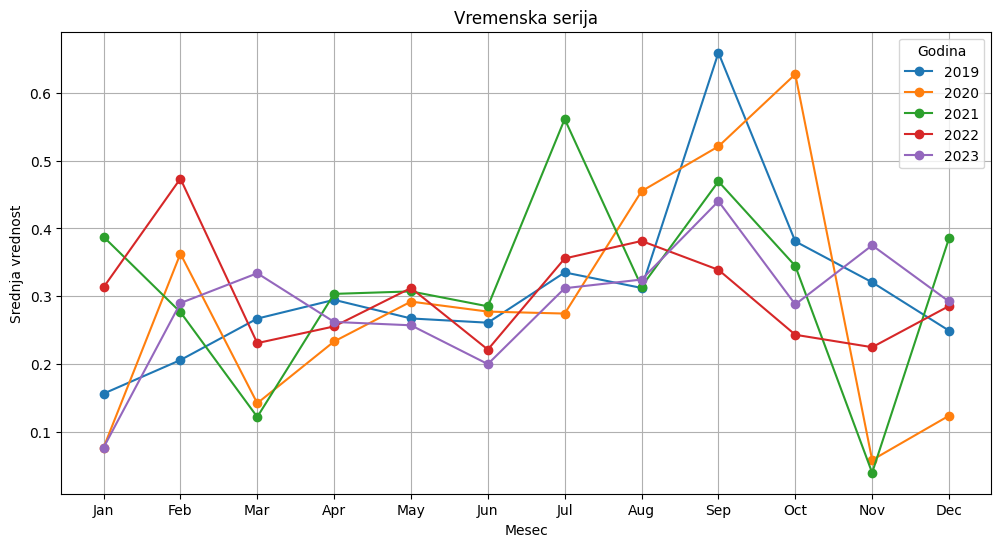

In [11]:
plot_time_series(group_data_ndvi)

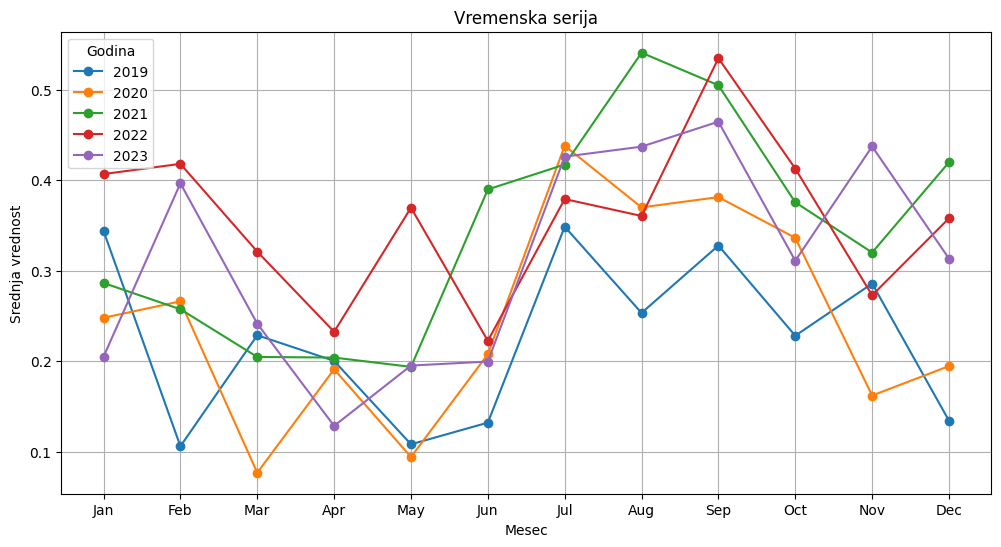

In [12]:
plot_time_series(group_data_moisi)

<Figure size 1200x600 with 0 Axes>

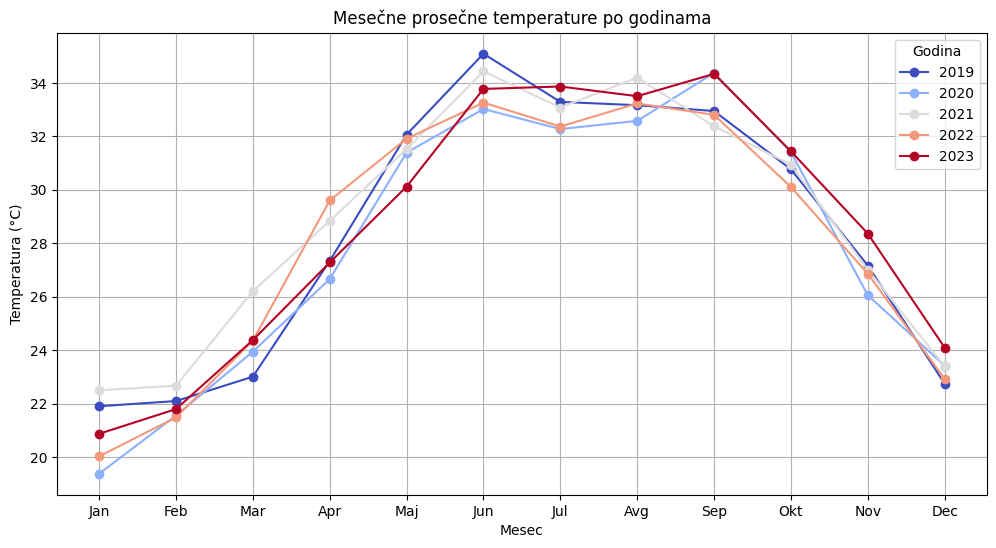

In [13]:
plot_monthly_temperature(df_temp)

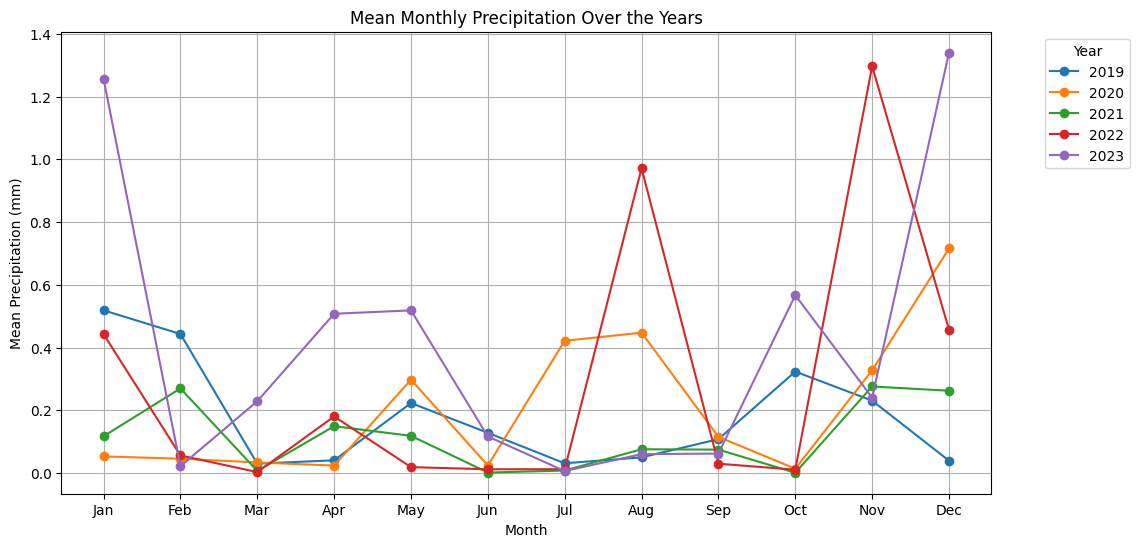

In [21]:
plot_precipitation_by_month(df_prec)

In [15]:
ndvi_min, ndvi_max = -1, 1
temp_min, temp_max = -50, 50
precip_min, precip_max = 0, 50

df_ndvi["B0_mean_scaled"] = (df_ndvi["B0_mean"] - ndvi_min) / (ndvi_max - ndvi_min)
df_temp["t2m_scaled"] = (df_temp["t2m"] - temp_min) / (temp_max - temp_min)
df_prec["precip_scaled"] = (df_prec["precip"] - precip_min) / (precip_max - precip_min)

df=calculate_vri(df_ndvi, df_moisi, df_temp, df_prec,NUTS3) 

In [16]:
df.to_csv(f"dataPBI/{NUTS3}_VRI.csv")

In [17]:
df.head()

,year,month,NUTS3,B0_mean_MOISI,B0_mean_scaled,precip_scaled,t2m_scaled,NDVI_before,VRI
0,2019,1,EVVIA,0.343837,0.578315,0.010374,0.719106,0.578315,0.602079
1,2019,2,EVVIA,0.106081,0.603064,0.008866,0.721047,0.578315,0.563638
2,2019,3,EVVIA,0.228713,0.633599,0.000599,0.730167,0.603064,0.596106
3,2019,4,EVVIA,0.200373,0.647419,0.000811,0.773440,0.633599,0.572489
4,2019,5,EVVIA,0.108261,0.633703,0.004459,0.820670,0.647419,0.526331


In [18]:
print("df_ndvi columns:", df_ndvi.columns)
print("df_moisi columns:", df_moisi.columns)
print("df_temp columns:", df_temp.columns)
print("df_prec columns:", df_prec.columns)


df_ndvi columns: Index(['from', 'to', 'B0_min', 'B0_max', 'B0_mean', 'B0_stDev', 'B1_min',
       'B1_max', 'B1_mean', 'B1_stDev', 'B2_min', 'B2_max', 'B2_mean',
       'B2_stDev', 'year', 'month', 'B0_mean_scaled', 'NUTS3'],
      dtype='object')
df_moisi columns: Index(['from', 'to', 'B0_min', 'B0_max', 'B0_mean', 'B0_stDev', 'B1_min',
       'B1_max', 'B1_mean', 'B1_stDev', 'B2_min', 'B2_max', 'B2_mean',
       'B2_stDev', 'B3_min', 'B3_max', 'B3_mean', 'B3_stDev', 'index_min',
       'index_max', 'index_mean', 'index_stDev', 'eobrowserStats_B0_min',
       'eobrowserStats_B0_max', 'eobrowserStats_B0_mean',
       'eobrowserStats_B0_stDev', 'eobrowserStats_B1_min',
       'eobrowserStats_B1_max', 'eobrowserStats_B1_mean',
       'eobrowserStats_B1_stDev', 'year', 'month', 'NUTS3'],
      dtype='object')
df_temp columns: Index(['time', 'latitude', 'longitude', 'number', 'step', 'surface',
       'valid_time', 't2m', 'year', 'month', 't2m_scaled', 'NUTS3'],
      dtype='object')
df_pr

In [20]:
print("df_ndvi unique (year, month, NUTS3):")
print(df_ndvi[["year", "month", "NUTS3"]].drop_duplicates())

print("df_moisi unique (year, month, NUTS3):")
print(df_moisi[["year", "month", "NUTS3"]].drop_duplicates())

print("df_temp unique (year, month, NUTS3):")
print(df_temp[["year", "month", "NUTS3"]].drop_duplicates())

print("df_prec unique (year, month, NUTS3):")
print(df_prec[["year", "month", "NUTS3"]].drop_duplicates())


df_ndvi unique (year, month, NUTS3):
    year  month  NUTS3
0   2019      1  EVVIA
1   2019      2  EVVIA
2   2019      3  EVVIA
3   2019      4  EVVIA
4   2019      5  EVVIA
5   2019      6  EVVIA
6   2019      7  EVVIA
7   2019      8  EVVIA
8   2019      9  EVVIA
9   2019     10  EVVIA
10  2019     11  EVVIA
11  2019     12  EVVIA
12  2020      1  EVVIA
13  2020      2  EVVIA
14  2020      3  EVVIA
15  2020      4  EVVIA
16  2020      5  EVVIA
17  2020      6  EVVIA
18  2020      7  EVVIA
19  2020      8  EVVIA
20  2020      9  EVVIA
21  2020     10  EVVIA
22  2020     11  EVVIA
23  2020     12  EVVIA
24  2021      1  EVVIA
25  2021      2  EVVIA
26  2021      3  EVVIA
27  2021      4  EVVIA
28  2021      5  EVVIA
29  2021      6  EVVIA
30  2021      7  EVVIA
31  2021      8  EVVIA
32  2021      9  EVVIA
33  2021     10  EVVIA
34  2021     11  EVVIA
35  2021     12  EVVIA
36  2022      1  EVVIA
37  2022      2  EVVIA
38  2022      3  EVVIA
39  2022      4  EVVIA
40  2022      5  EVV

In [19]:
print(df_ndvi.dtypes)
print(df_moisi.dtypes)
print(df_temp.dtypes)
print(df_prec.dtypes)


from              datetime64[ns, UTC]
to                datetime64[ns, UTC]
B0_min                        float64
B0_max                        float64
B0_mean                       float64
B0_stDev                      float64
B1_min                        float64
B1_max                        float64
B1_mean                       float64
B1_stDev                      float64
B2_min                        float64
B2_max                        float64
B2_mean                       float64
B2_stDev                      float64
year                            int32
month                           int32
B0_mean_scaled                float64
NUTS3                          object
dtype: object
from                       datetime64[ns, UTC]
to                         datetime64[ns, UTC]
B0_min                                 float64
B0_max                                 float64
B0_mean                                float64
B0_stDev                               float64
B1_min              

In [ ]:
df_new=generate_vri(NUTS3, bbox, years, key)

In [ ]:
df_new.head()